# Assignment 5

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [1]:
from bs4 import BeautifulSoup
import re
import requests, requests_cache
requests_cache.install_cache("cache")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from os import path
import nltk
from nltk import corpus
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from __future__ import division
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from heapq import nlargest


In [24]:
def extract_links(url, pages):
    """Input: website link, number of pages to fetch links from
    Output: all links from the website
    """
    links = []
    for page in range(1,pages+1):
        urls = url + 'page/' + str(page) + '/'
        html_page = requests.get(urls)
        soup = BeautifulSoup(html_page.text)

        for link in soup.findAll('a',rel='bookmark',href = True):
            links.append(link['href'])
    return links

pages = 4
url = "https://theaggie.org/campus/"
#extract_links(url,pages)

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

*   Python 2 displays some Unicode characters as `\uXXXX`. For instance, `\u201c` is a left-facing quotation mark.
    You can convert most of these to ASCII characters with the method call (on a string)
    ```
    .translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    ```
    If you're curious about these characters, you can look them up on [this page](http://unicode.org/cldr/utility/character.jsp), or read 
    more about [what Unicode is](http://unicode.org/standard/WhatIsUnicode.html).

In [3]:
samplearticle='https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'

def extract_article(url):
    """Input: URL of the article
    Output: extracts the title, text, and author of an article"""
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.text)
    title = soup.title.string
    text = soup.get_text()
    author = soup(text=re.compile('Written'))
    paragraphs = soup.find_all('p')#[:-2]
    body=[]
    for paragraph in paragraphs:
        if paragraph.text.startswith('Written') or paragraph.text.startswith('You must be logged in to post a comment'):
            body = body
        else:
            body.append(paragraph.text)
    body = ''.join(body)
    body = body.translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    d = {"url": url, "title": title, "text": body, "author": author}
    return d
#extract_article(samplearticle)

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [4]:
cap = pd.DataFrame()
cap_links = extract_links('https://theaggie.org/campus/',4)
for cap_l in cap_links:
    d = extract_article(cap_l)

    s  = pd.Series(d, d.keys())
    #s['category'] = 'campus news'
    cap = cap.append(s, ignore_index=True)
cap['category'] = ['campus news'] * len(cap) # DataFrame for Campus News

city = pd.DataFrame()
ct_links = extract_links('https://theaggie.org/city/',4)
for ct_l in ct_links:
    d = extract_article(ct_l)
    s  = pd.Series(d, d.keys())
    city = city.append(s, ignore_index=True)
city['category'] = ['city news'] * len(city) # DataFrame for City News

df = cap.append(city) # Combined Campus-News & City-News DataFrames
df = df.reset_index(drop=True)
df.head()

,author,text,title,url,category
0,[Written by: Alyssa Vandenberg — campus@theag...,UC Board of Regents to vote on the appointment...,UC President selects Gary May as new UC Davis ...,https://theaggie.org/2017/02/21/uc-president-s...,campus news
1,[Written by: Jeanna Totah — ],Tighter policies require greater approval of o...,Katehi controversy prompts decline of UC admin...,https://theaggie.org/2017/02/20/katehi-controv...,campus news
2,[Written by: Ivan Valenzuela — ],SR #7 asks university to increase capacity for...,ASUCD Senate passes resolution submitting comm...,https://theaggie.org/2017/02/20/asucd-senate-p...,campus news
3,[Written by: Yvonne Leong — ],UC Davis leads in sustainability with largest ...,UC releases 2016 Annual Report on Sustainable ...,https://theaggie.org/2017/02/20/uc-releases-20...,campus news
4,[Written by: Kenton Goldsby — campus@theaggie....,"Speakers, including Interim Chancellor Ralph J...",UC Davis Global Affairs holds discussion on Pr...,https://theaggie.org/2017/02/19/uc-davis-globa...,campus news


__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

<strong>Question 1:</strong>  What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

In [5]:
def filter_df(dataframe):
    result = []
    for i in range(len(dataframe)):
        df = dataframe[i] # string
        final = filter_text(df)
        result.append(final)
    return result

def filter_text(text):
    """Input: dataframe of one column
    Output: tokenized -> lowercase -> get ride of stopwords -> stemmed = result"""
    token = nltk.word_tokenize(text)
    lower = [tok.lower() for tok in token]
    text = []
    for w in lower: 
        if w not in stopwords.words("english"):
            if w.isalnum():
                text.append(w)
    stemmer = PorterStemmer().stem
    final = [stemmer(w.encode('ascii','ignore')) for w in text]
    return final

def string_df(result):
    str1 = ' '.join(str(r) for v in result for r in v)
    return str1

def string_tx(result):
    str1 = ' '.join(str(v) for v in result)
    return str1

def most_common_word(text):
    """Input: text in dataframe form
    Output: most common words in that text"""
    fdist_text = FreqDist(text.split())
    return fdist_text.most_common(len(fdist_text))

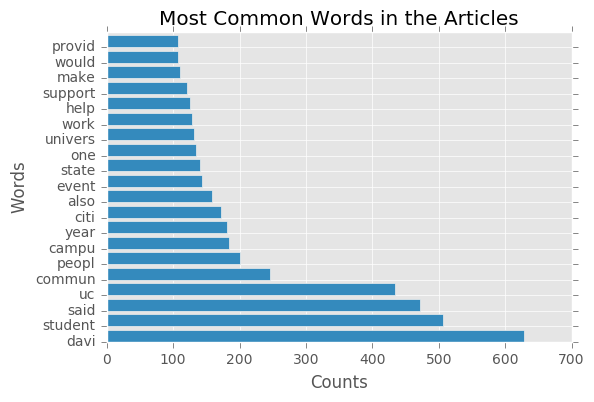

In [6]:
def plot_mostcom(text, n):
    """Input: dataframe that contains a column of what you want to plot with;
    number of words
    Output: bar graph of the most common words with their frequencies"""
    freq = most_common_word(text)
    f = freq[:n]
    num1 = []
    words = []
    for i in range(len(f)):
        num1.append(f[i][1])
    for j in range(len(f)):
        words.append(f[j][0])
    plt.barh(range(len(words)),num1)
    plt.yticks(range(len(f)),words)
    plt.title('Most Common Words in the Articles')
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.show()
    
f = df['text']
text = string_df(filter_df(f))
plot_mostcom(text,20)

The most common topics that the Aggies cover are topics related to UC Davis or the city of Davis. For example, topics like: UC Davis, students, community, campus, what happend that year, events, work, and some advertising of needing people's support or help.

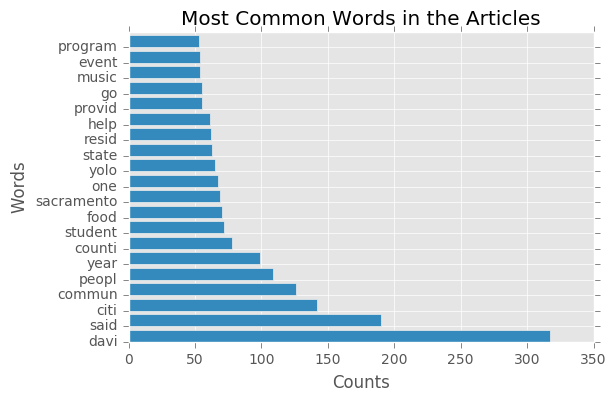

In [7]:
f = city['text'] # City News
text = string_df(filter_df(f))
plot_mostcom(text,20)

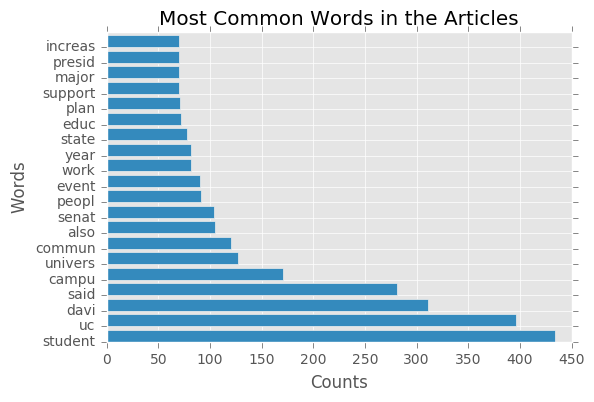

In [8]:
f = cap['text'] # Campus News
text = string_df(filter_df(f))
plot_mostcom(text,20)

City News articles typically cover different topics than Campus News articles. City News covers topics that are mostly related to a more broad area of Davis to Yolo county. For example, topics like: Davis, community, yolo county, sacramento, food, state, residents, music, and programs. Campus News covers topics that are mostly related to UC Davis and students. For example, topics like: students, UC Davis, campus, community, senate, events, education, plans, major, and probably student president. They both cover topics that are related to Davis and the communities, but for the most part they are different. 

<strong>Question 2:</strong><p>What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?</p>

In [9]:
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))

In [100]:
reuters = df['text']
title = df['title']

vectorizer = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)
tfs = vectorizer.fit_transform(reuters)
sim = tfs.dot(tfs.T)

def matrix_index(value):
    """Input: value in the matrix
    Output: index of the matrix, sim"""
    for i in range(len(reuters)):
        for j in range(len(reuters)):
            if sim[i,j] == value:
                return i, j
def top_3():
    mat = sim.tocoo()
    data = mat.data
    top_3 = nlargest(125, range(len(data)), key=lambda i: data[i])
    return data[top_3[120]],data[top_3[122]],data[top_3[124]]

tops = top_3()
title_id = (matrix_index(tops[0]),matrix_index(tops[1]),matrix_index(tops[2]))
#print title_id

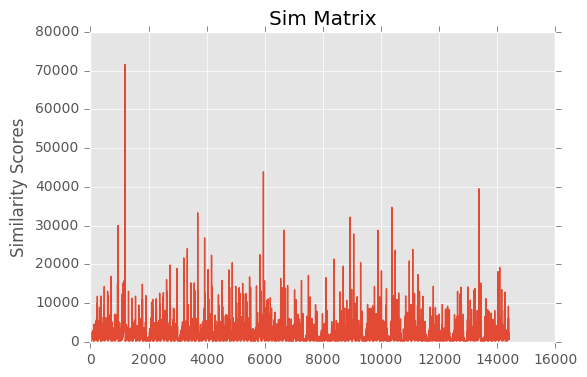

In [11]:
mat = sim.tocoo()
data = mat.data
plt.plot(data)
plt.title('Sim Matrix')
plt.ylabel('Similarity Scores')

plt.show()

The titles of the top 3 pairs of most similar articles:

In [12]:
print title[title_id[0][0]]
print title[title_id[0][1]]
print title[title_id[1][0]]
print title[title_id[1][1]]
print title[title_id[2][0]]
print title[title_id[2][1]]

2017 ASUCD Winter Elections — Meet the Candidates | The Aggie
Yolo County Farm Bureau to honor Local Winery | The Aggie
2017 ASUCD Winter Elections — Meet the Candidates | The Aggie
City of Davis to retain sanctuary city status | The Aggie
UC, CSU systems consider first tuition increases after five-year tuition freeze | The Aggie
Students walk out of classes to protest potential tuition hikes | The Aggie


In [13]:
def extract_words(r):
    text = string_tx(filter_text(r)) # text file method
    t = most_common_word(text)
    words = []
    for j in range(len(t)):
        words.append(t[j][0])
    return words

def extract_values(r):
    text = string_tx(filter_text(r)) # text file method
    t = most_common_word(text)
    num = []
    for j in range(len(t)):
        num.append(t[j][1])
    return num

def sim_words(r1, r2):
    simi = []
    r1_w = extract_words(r1)
    r2_w = extract_words(r2)

    for w1 in r1_w:
        if w1 in r2_w:
            simi.append(w1)
    return simi


In [14]:
def dic(word,num):
    r_dict = {}
    for i in range(len(num)):
        r_dict[word[i]] = num[i]
    return r_dict

def plotrr(r1,r2):
    r1_num = extract_values(r1)
    r1_word = extract_words(r1)
    r2_num = extract_values(r2)
    r2_word = extract_words(r2)
    simvr1 = []
    simvr2 = []
    for w in sim_words(r1, r2):
        simvr1.append(dic(r1_word,r1_num)[w])
        simvr2.append(dic(r2_word,r2_num)[w])
    index = range(len(simvr1))
    plt.bar(index, simvr1, color = 'b', label = 'article #1')
    plt.bar(index, simvr2, color = 'g', label = 'article #2')
    plt.xticks(index, sim_words(r1, r2), rotation = 90, fontsize = 7)
    plt.title('Common Words Between the 2 Articles')
    plt.xlabel('Words')
    plt.ylabel('counts')
    plt.legend()
    plt.show()

In [15]:
print title[title_id[0][0]]
print title[title_id[0][1]]

2017 ASUCD Winter Elections — Meet the Candidates | The Aggie
Yolo County Farm Bureau to honor Local Winery | The Aggie


Common words for these 2 articles:

In [16]:
r1 = reuters[title_id[0][0]]
r2 = reuters[title_id[0][1]]
print sim_words(r1, r2)

['said', 'want', 'commun', 'davi', 'work', 'help', 'make', 'includ', 'uc', 'would', 'come', 'go', 'govern', 'one', 'like', 'peopl', 'polit', 'see', 'year', 'thing', 'provid', 'need', 'current', 'scienc', 'person', 'repres', 'decid', 'tri', 'group', 'good', 'organ', 'someth', 'someon', 'money', 'represent', 'past', 'hold', 'whatev', 'advocaci', 'talk', 'anyth', 'theme', 'financ', 'well', 'execut', 'around', 'big', 'opportun', 'agricultur', 'way', 'everi', 'chang', 'establish', 'high', 'influenc', 'situat', 'mind', 'without', 'local', 'addit', 'educ', 'howev', 'receiv', 'assist', 'support', 'regard', 'us']


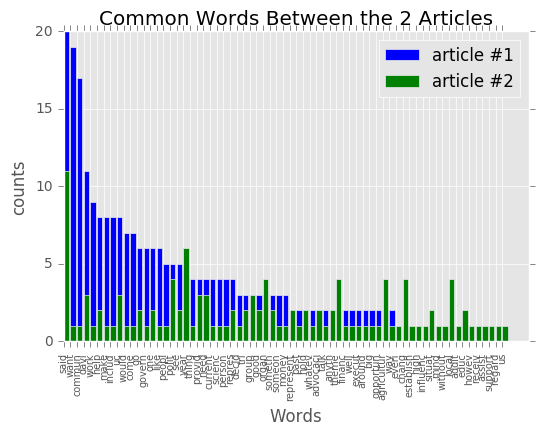

In [17]:
plotrr(r1,r2)

In [18]:
print title[title_id[1][0]]
print title[title_id[1][1]]

2017 ASUCD Winter Elections — Meet the Candidates | The Aggie
City of Davis to retain sanctuary city status | The Aggie


Common words for these 2 articles:

In [19]:
r1 = reuters[title_id[1][0]]
r2 = reuters[title_id[1][1]]
print sim_words(r1, r2)

['said', 'major', 'davi', 'work', 'make', 'includ', 'uc', 'think', 'come', 'go', 'like', 'peopl', 'polit', 'undocu', 'know', 'thing', 'need', 'fund', 'scienc', 'tri', 'public', 'live', 'order', 'good', 'citi', 'posit', 'show', 'someth', 'someon', 'offic', 'day', 'term', 'presid', 'kind', 'sanctuari', 'busi', 'statu', 'execut', 'around', 'right', 'way', 'follow', 'ticket', 'administr', 'new', 'sinc', 'chang', 'unit', 'anyon', 'polici', 'somebodi', 'happen', 'system', 'without', 'noth', 'determin', 'mani', 'receiv', 'contact', 'english', 'resid', 'stanc', 'offer', 'possibl']


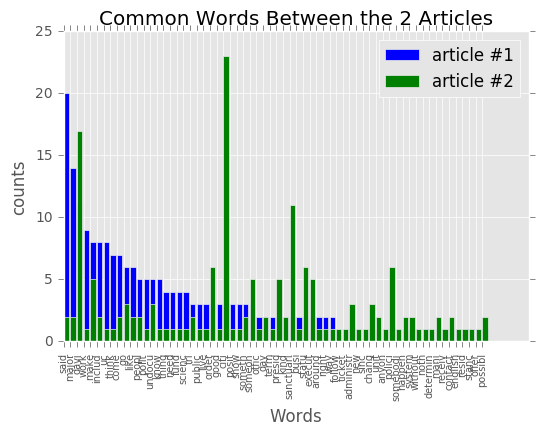

In [20]:
plotrr(r1,r2)

In [21]:
print title[title_id[2][0]]
print title[title_id[2][1]]

UC, CSU systems consider first tuition increases after five-year tuition freeze | The Aggie
Students walk out of classes to protest potential tuition hikes | The Aggie


Common words for these 2 articles:

In [22]:
r1 = reuters[title_id[2][0]]
r2 = reuters[title_id[2][1]]
print sim_words(r1, r2)

['tuition', 'increas', 'uc', 'student', 'time', 'said', 'state', 'california', 'univers', 'educ', 'system', 'fund', 'take', 'year', 'work', 'could', 'think', 'fee', 'percent', 'plan', 'protest', 'particip', 'alreadi', 'davi', 'need', 'higher', 'demonstr', 'campu', 'fall', 'rest', 'go', 'cut', 'regent', 'creat', 'rollback', 'around', 'one', 'tri', 'right', 'significantli', 'event', 'freez', 'letter', 'afford', 'colleg', 'ensur', 'spoke', 'messag', 'regard', 'made', 'hike', 'ago', 'scienc', 'us', 'potenti']


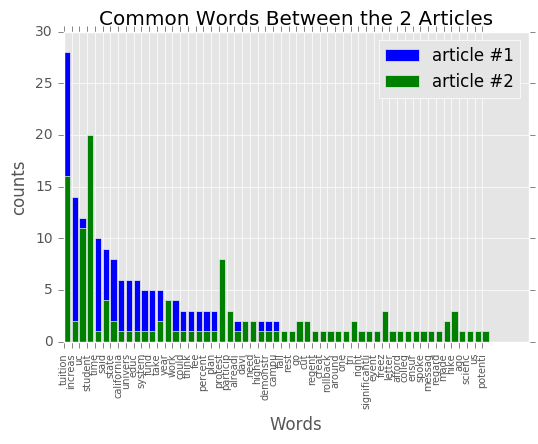

In [23]:
plotrr(r1,r2)

<strong>Question 3:</strong>  Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.
<p>I think this corpus cannot be a representation of the Aggie, because this corpus only contains 120 articles, and there are many more articles that are not included in the corpus. Also, there are only two catagories in the corpus. We should include all the articles by all different catagories in order to say it is a representation of the Aggie.</p><p>
This corpus can be the representative of the most recent Aggie News, since the News catagory only contains Campus News and City News. Also, since we are only including the first 60 news from both Campus and City news, this means that the news are all up to date and recent.</p>